평가 척도 : 다중 클래스 정확률

In [1]:
# ! kaggle competitions list
# ! kaggle competitions download -c tensorflow-speech-recognition-challenge
# ! unzip -qq "tensorflow-speech-recognition-challenge.zip"

In [2]:
import IPython.display as ipd
from scipy.io import wavfile
import librosa

# 음성 파일 경로를 지정한다
data_dir = ''
train_audio_path = data_dir + 'train/train/audio/'
filename = 'yes/e4b02540_nohash_0.wav'

# 음성 데이터 읽어오기
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)

# Player 실행
ipd.Audio(samples, rate=sample_rate)

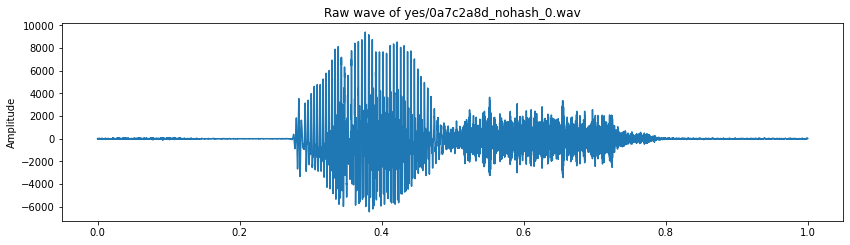

In [3]:
import numpy as np
from scipy import signal

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import librosa
import librosa.display 

# 음성 파일 경로를 지정한다
data_dir = ''
train_audio_path = data_dir + 'train/train/audio/'
filename = 'yes/0a7c2a8d_nohash_0.wav'
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)

# 음성 파형 (sound wave)를 시각화한다
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

Text(0.5, 0, 'Seconds')

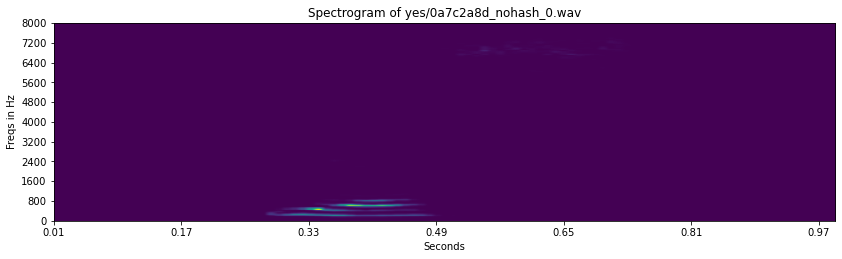

In [4]:
# 스펙트로그램을 계산하는 함수
def specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    """
    sample_rate : 초당 데이터 추출 수
    """
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, spec.T.astype(np.float32)

# 스펙트로그램을 시각화한다
freqs, times, spectrogram = specgram(samples, sample_rate)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax1.set_yticks(freqs[::16])
ax1.set_xticks(times[::16])
ax1.set_title('Spectrogram of ' + filename)
ax1.set_ylabel('Freqs in Hz')
ax1.set_xlabel('Seconds')

Text(0.5, 0, 'Seconds')

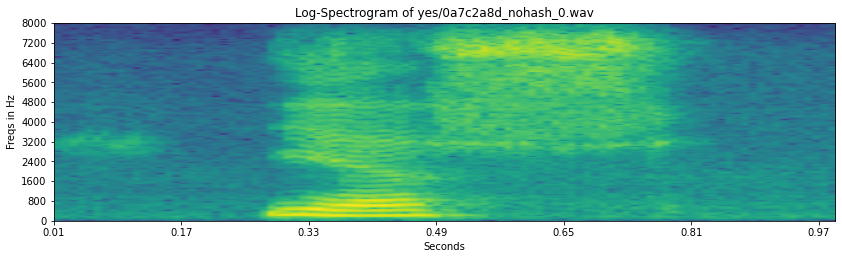

In [36]:
# log-스펙트로그램을 계산하는 함수
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

# log-스펙트로그램을 시각화한다
freqs, times, log_spectrogram = log_specgram(samples, sample_rate)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.imshow(log_spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax1.set_yticks(freqs[::16])
ax1.set_xticks(times[::16])
ax1.set_title('Log-Spectrogram of ' + filename)
ax1.set_ylabel('Freqs in Hz')
ax1.set_xlabel('Seconds')

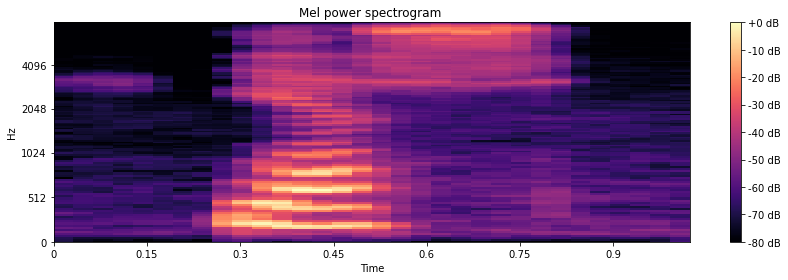

In [5]:
# mel-스펙트로그램을 계산하는 함수
S = librosa.feature.melspectrogram(samples.astype(np.float16), sr=sample_rate, n_mels=128)
log_S = librosa.power_to_db(S, ref=np.max)

# mel-스펙트로그램을 시각화한다
plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

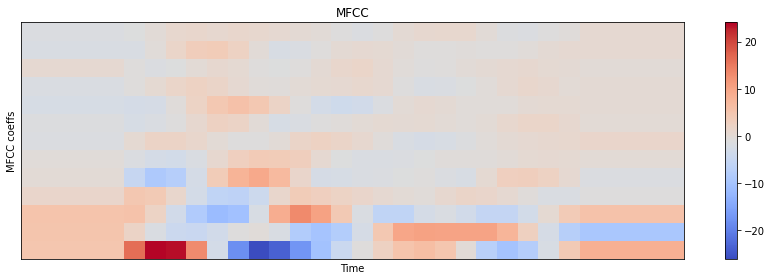

In [6]:
# MFCC를 계산하는 함수
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

# MFCC를 시각화한다
plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

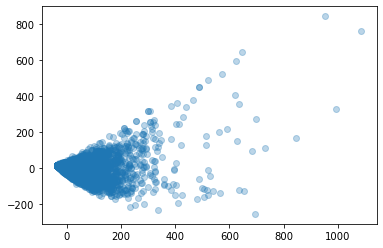

In [20]:
# 데이터의 이상치를 제거해야한다.(소리가 없는 데이터 등등)
# 푸리에 변환을 통하여 약 8000개의 특성을 만들고, 시각화를 위하여 차원축소를 하여 가장 멀리 있는 점을 이상치로 판단 한다. 
import numpy as np
from scipy.fftpack import fft
import os

def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])
    return xf, vals

train_audio_path = 'train/train/audio/'
dirs = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
fft_all = []
names = []
for direct in dirs:
    waves = [f for f in os.listdir(os.path.join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + direct + '/' + wav)
        if samples.shape[0] != sample_rate:
            samples = np.append(samples, np.zeros((sample_rate - samples.shape[0], )))
        x, val = custom_fft(samples, sample_rate)
        fft_all.append(val)
        names.append(direct + '/' + wav)

fft_all = np.array(fft_all)

# 데이터를 정규화한다
fft_all = (fft_all - np.mean(fft_all, axis=0)) / np.std(fft_all, axis=0)

# PCA를 통해 2차원으로 축소한다
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
fft_all = pca.fit_transform(fft_all)

# 축소된 데이터를 시각화한다
plt.scatter(x=fft_all[:,0], y=fft_all[:,1], alpha=0.3)

In [12]:
# 800이상인 데이터를 이상치로 판단하고 확인
for i in np.where(fft_all[:,0] > 800)[0]:
    print(names[i])

yes/5165cf0a_nohash_0.wav
yes/617de221_nohash_1.wav
yes/e4b02540_nohash_0.wav
stop/de41f895_nohash_1.wav


In [24]:
# 소음을 추가하여 augmentation
import IPython.display as ipd
from scipy.io import wavfile
import random
import os

# 음성 파일 경로를 지정한다
train_audio_path = data_dir + 'train/train/audio/'
filename = 'yes/0a7c2a8d_nohash_0.wav'

# 음성 데이터을 읽어온다
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)

# 음성 위치를 200ms~800ms 사이의 값으로 랜덤하게 이동한다
shift_range = random.randint(200, 800)
shift = sample_rate * 100 // 1000
shift = random.randint(-shift, shift)
a = -min(0, shift)
b = max(0, shift)
sample_aug = np.pad(samples, (a, b), "constant").astype(np.float16)
sample_aug = sample_aug[:len(sample_aug) - a] if a else sample_aug[b:]

# 제공된 배경 소음 중, 랜덤으로 1초 가량의 소음을 추가한다
max_ratio = random.choice([0.1, 0.5, 1, 1.5])
noise_filenames = [f for f in os.listdir(os.path.join(train_audio_path, '_background_noise_')) if f.endswith('.wav')]
noise_filename = noise_filenames[random.randint(0, len(noise_filenames)-1)]
_, noise_samples = wavfile.read(str(train_audio_path) + '_background_noise_/' + noise_filename)
start_idx = random.randint(0, len(noise_samples) - 1 - sample_rate)
noise_samples = noise_samples[start_idx:(start_idx + sample_rate)]
max_ratio = random.choice([0.1, 0.5, 1, 1.5])
sample_aug += max_ratio * random.random() * noise_samples.astype(np.float16)

# 파형의 높이를 스케일링한다
scale = random.uniform(0.75, 1.25)
sample_aug *= scale

# Data Augmentation을 취한 음성 파일을 들어본다
ipd.Audio(sample_aug- noise_samples, rate=sample_rate)

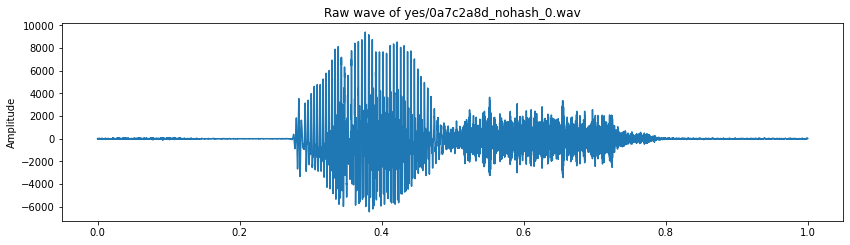

In [32]:
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

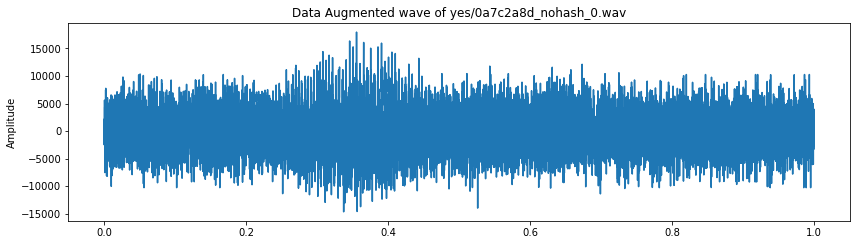

In [33]:
# 소음을 추가하여 augmentation
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Data Augmented wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(noise_samples), sample_rate), -noise_samples + sample_aug)

Text(0.5, 0, 'Seconds')

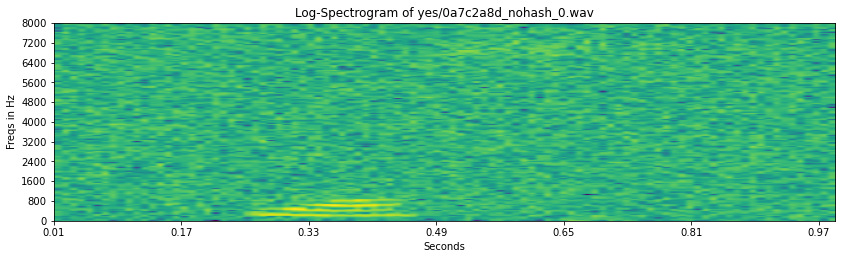

In [37]:
# log-스펙트로그램으로 데이터 augmentation 시각화한다
freqs, times, log_spectrogram = log_specgram(sample_aug - noise_samples, sample_rate)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.imshow(log_spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax1.set_yticks(freqs[::16])
ax1.set_xticks(times[::16])
ax1.set_title('Log-Spectrogram of ' + filename)
ax1.set_ylabel('Freqs in Hz')
ax1.set_xlabel('Seconds')